## Settings

In [ ]:
GDRIVE_ID_VALENCE = '1qqo7z4GnZ6-gtyyT_aVUKX7uaECXVUh8'
GDRIVE_ID_AROUSAL = '1zUQc_QEpFfV7wBTAlpzVMa5DnYQ03XX2'
GDRIVE_ID_FER = '139hpFUxh9toyU0LwDq7mibYr6HjJgh6f'
GDRIVE_ID_TEST_IMGS_ZIP = '1Ty8MiMMPopdp7AVycD8Df7rNDKW5U97H'

SAVED_MODEL_VALENCE_PATH = 'saved_model_infr_valence.h5'
SAVED_MODEL_AROUSAL_PATH = 'saved_model_infr_arousal.h5'
SAVED_MODEL_FER_PATH = 'saved_model_infr_fer.h5'
TEST_IMGS_PATH = 'test_imgs'

## Downloads

In [ ]:
!gdown -O {SAVED_MODEL_VALENCE_PATH} --id {GDRIVE_ID_VALENCE}
!gdown -O {SAVED_MODEL_AROUSAL_PATH} --id {GDRIVE_ID_AROUSAL}
!gdown -O {SAVED_MODEL_FER_PATH} --id {GDRIVE_ID_FER}
!gdown -O {TEST_IMGS_PATH}.zip --id {GDRIVE_ID_TEST_IMGS_ZIP}

!unzip -q {TEST_IMGS_PATH}.zip  # quiet

Downloading...
From: https://drive.google.com/uc?id=1qqo7z4GnZ6-gtyyT_aVUKX7uaECXVUh8
To: /content/saved_model_infr_valence.h5
100% 1.06M/1.06M [00:00<00:00, 70.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zUQc_QEpFfV7wBTAlpzVMa5DnYQ03XX2
To: /content/saved_model_infr_arousal.h5
100% 1.06M/1.06M [00:00<00:00, 70.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=139hpFUxh9toyU0LwDq7mibYr6HjJgh6f
To: /content/saved_model_infr_fer.h5
100% 1.19M/1.19M [00:00<00:00, 79.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ty8MiMMPopdp7AVycD8Df7rNDKW5U97H
To: /content/test_imgs.zip
100% 437k/437k [00:00<00:00, 52.4MB/s]


In [ ]:
from pathlib import Path

assert Path(SAVED_MODEL_VALENCE_PATH).is_file(), f'"{SAVED_MODEL_VALENCE_PATH}" file is required'
assert Path(SAVED_MODEL_AROUSAL_PATH).is_file(), f'"{SAVED_MODEL_AROUSAL_PATH}" file is required'
assert Path(SAVED_MODEL_FER_PATH).is_file(), f'"{SAVED_MODEL_FER_PATH}" file is required'

## Imports

In [ ]:
from time import time
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import tensorflow as tf

from tqdm import tqdm

/print tf.__version__

2.7.0


## Definitions

In [ ]:
#@title { display-mode: "form", form-width: "1px" }
#@markdown ```python
#@markdown # Functions
#@markdown read_images(paths, size=None, mode='rgb', return_skipped=False)
#@markdown imshow_valence_arousal(img, valence, arousal, title=None)
#@markdown ```
def read_images(paths, size=None, mode='rgb', return_skipped=False):
    """
    Example, no resize:

    >>> [img.shape for img in read_images(paths[:3], size=None)]
    [(201, 201, 3), (231, 231, 3), (296, 296, 3)]

    Example, with resize:

    >>> imgs = read_images(paths[:2], size=(100, 50))
    >>> imgs.shape
    (2, 50, 100, 3)
    """
    assert mode in ['rgb', 'bgr', 'gray', 'gray_1ch']

    n = len(paths)
    skipped_files = []

    if size is None:
        imgs = [None] * n
    else:
        w, h = size
        if mode == 'gray':
            imgs = np.zeros((n, h, w), dtype=np.uint8)
        elif mode == 'gray_1ch':
            imgs = np.zeros((n, h, w, 1), dtype=np.uint8)
        else:
            imgs = np.zeros((n, h, w, 3), dtype=np.uint8)

    i = 0
    for path in tqdm(paths):
        if mode in ['rgb', 'bgr']:
            img = cv2.imread(path, cv2.IMREAD_COLOR)      # (h, w, 3)
        elif mode in ['gray', 'gray_1ch']:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # (h, w)
        if img is None:
            skipped_files.append(path)
            continue
        if mode == 'rgb':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if size is not None:
            if sum(img.shape[:2]) > sum(size):
                # Current size > Target size
                img = cv2.resize(img, (w, h), cv2.INTER_AREA)  # downscale
            else:
                img = cv2.resize(img, (w, h), cv2.INTER_LINEAR)  # upscale
        if mode == 'gray_1ch':
            img = img[..., None]  # (h, w) -> (h, w, 1)

        imgs[i] = img
        i += 1
    
    if i < n:
        print(f"{i}/{n} files have been read")
        imgs = imgs[:i]
    
    if return_skipped:
        return (imgs, skipped_files)
    else:
        return imgs


def imshow_valence_arousal(img, valence, arousal, title=None):
    grid_size = 20
    fig = plt.figure(figsize=(5, 5), )
    gs = GridSpec(grid_size, grid_size, figure=fig)

    span = grid_size - 1
    ax1 = fig.add_subplot(gs[:span, 1:span + 1])
    ax2 = fig.add_subplot(gs[span, 1:span + 1])  # horizontal bar
    ax3 = fig.add_subplot(gs[:span, 0])          # vertical bar

    ax1.imshow(img, cmap='gray')
    ax1.set_axis_off()

    ax2.barh('valence', valence)
    ax2.set_yticks([])
    ax2.set_frame_on(False)
    ax2.set_xlim(-4.5, 4.5)
    ax2.set_xlabel('Valence (-unpleasant / +pleasant)', rotation=0)
    ax2.axvline(0, c='k')

    ax3.bar('arousal', arousal)
    ax3.set_xticks([])
    ax3.set_frame_on(False)
    ax3.set_ylim(-4.5, 4.5)
    ax3.set_ylabel('Arousal (-calm / +tense)', rotation=90)
    ax3.axhline(0, c='k')

    if title:
        ax1.set_title(title)

## Valence-arousal prediction demo

In [ ]:
model_valence = tf.keras.models.load_model(SAVED_MODEL_VALENCE_PATH)
model_arousal = tf.keras.models.load_model(SAVED_MODEL_AROUSAL_PATH)

100%|██████████| 4/4 [00:00<00:00, 60.49it/s]


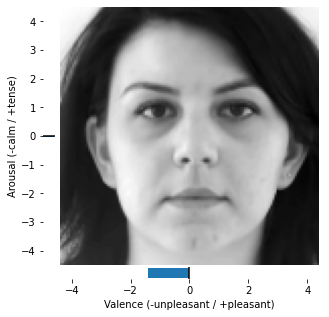

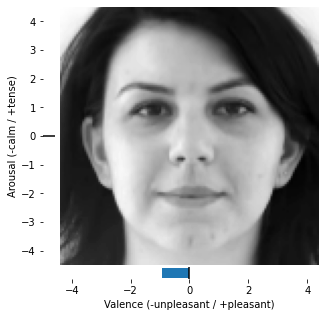

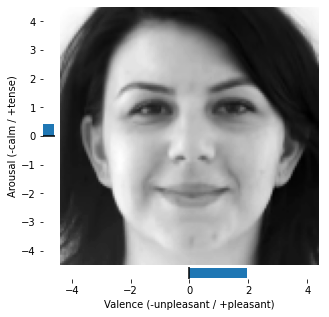

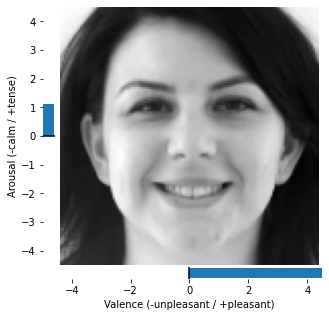

In [ ]:
images = read_images(['10.png', '11.png', '12.png', '13.png'], (128, 128), mode='gray_1ch')
pred_valence = model_valence.predict(images)
pred_arousal = model_arousal.predict(images)
for i in range(4):
    imshow_valence_arousal(images[i, ..., 0], pred_valence[i], pred_arousal[i])

100%|██████████| 3/3 [00:00<00:00, 345.26it/s]


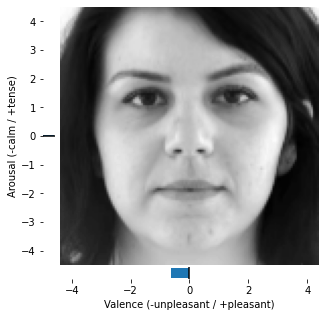

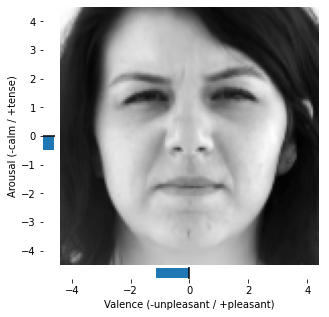

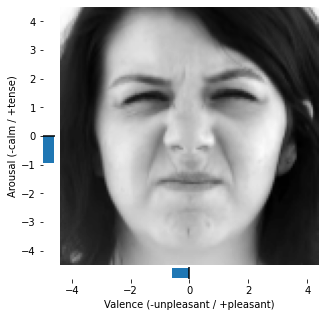

In [ ]:
images = read_images(['20.png', '21.png', '22.png'], (128, 128), mode='gray_1ch')
pred_valence = model_valence.predict(images)
pred_arousal = model_arousal.predict(images)
for i in range(3):
    imshow_valence_arousal(images[i, ..., 0], pred_valence[i], pred_arousal[i])

## Performance test

In [ ]:
model_valence = tf.keras.models.load_model(SAVED_MODEL_VALENCE_PATH)
model_arousal = tf.keras.models.load_model(SAVED_MODEL_AROUSAL_PATH)
model_fer = tf.keras.models.load_model(SAVED_MODEL_FER_PATH)

In [ ]:
# Warm up
warmup_input = np.random.randint(0, 256, size=(1, 128, 128, 1), dtype=np.uint8)
_ = model_valence(warmup_input, training=False)
_ = model_arousal(warmup_input, training=False)
_ = model_fer(warmup_input, training=False)

In [ ]:
def measure_infr_time(model, batches):
    t0 = time()
    for batch in tqdm(batches):
        _ = model(batch, training=False)
    return (time() - t0) / len(batches)

In [ ]:
# Generate test data
n = 32
random_batches = np.random.randint(0, 256, size=(n, 1, 128, 128, 1), dtype=np.uint8)

### CPU

In [ ]:
#@title Hardware report { display-mode: "form" }
def report_hardware():
    split_space = lambda s: list(filter(None, s.split()))

    # CPU
    cpu_info = !cat /proc/cpuinfo
    print('CPU: {}x {} @ cache {}'.format(len(cpu_info)//27, cpu_info[4][13:], cpu_info[8][13:]))

    # RAM
    mem_info = !cat /proc/meminfo
    mem_total_gb = int(split_space(mem_info[0])[1]) / 1024 / 1024
    mem_avail_gb = int(split_space(mem_info[2])[1]) / 1024 / 1024
    print('RAM: {0:.1f} GB total, {1:.1f} GB avail'.format(mem_total_gb, mem_avail_gb))

    # GPU
    from tensorflow.python.client import device_lib
    has_gpu = False
    for device in device_lib.list_local_devices():
        if device.device_type == 'GPU':
            has_gpu = True
            device_specs = dict(item.split(': ') for item in device.physical_device_desc.split(', '))
            print('GPU: {0} (name: "{1}", compute capability: {2}, memory: {3:.1f}GB)'.format(
                device_specs['name'],
                device.name,
                device_specs['compute capability'],
                device.memory_limit / 1024 / 1024 / 1024))
    if not has_gpu:
        print('GPU: none')

    # Disk
    disc_info = !df -h /content
    print('Disk: {1} total, {4} used, {3} avail'.format(*split_space(disc_info[1])))

report_hardware()

CPU: 2x Intel(R) Xeon(R) CPU @ 2.20GHz @ cache 56320 KB
RAM: 12.7 GB total, 11.7 GB avail
GPU: none
Disk: 108G total, 39% used, 67G avail


In [ ]:
# CPU
model_fer_s = measure_infr_time(model_fer, random_batches)
model_valence_s = measure_infr_time(model_valence, random_batches)
model_arousal_s = measure_infr_time(model_arousal, random_batches)

print(f'\nEmotion recognition: {model_fer_s:.3f}s/img ({1/model_fer_s:.0f}fps)'
      f'\nValence prediction: {model_valence_s:.3f}s/img ({1/model_valence_s:.0f}fps)'
      f'\nArousal prediction: {model_arousal_s:.3f}s/img ({1/model_arousal_s:.0f}fps)')

100%|██████████| 32/32 [00:01<00:00, 25.14it/s]


Emotion recognition: 0.041s/img (24fps)
Valence prediction: 0.041s/img (24fps)
Arousal prediction: 0.040s/img (25fps)


### GPU

In [ ]:
#@title Hardware report { display-mode: "form" }
def report_hardware():
    split_space = lambda s: list(filter(None, s.split()))

    # CPU
    cpu_info = !cat /proc/cpuinfo
    print('CPU: {}x {} @ cache {}'.format(len(cpu_info)//27, cpu_info[4][13:], cpu_info[8][13:]))

    # RAM
    mem_info = !cat /proc/meminfo
    mem_total_gb = int(split_space(mem_info[0])[1]) / 1024 / 1024
    mem_avail_gb = int(split_space(mem_info[2])[1]) / 1024 / 1024
    print('RAM: {0:.1f} GB total, {1:.1f} GB avail'.format(mem_total_gb, mem_avail_gb))

    # GPU
    from tensorflow.python.client import device_lib
    has_gpu = False
    for device in device_lib.list_local_devices():
        if device.device_type == 'GPU':
            has_gpu = True
            device_specs = dict(item.split(': ') for item in device.physical_device_desc.split(', '))
            print('GPU: {0} (name: "{1}", compute capability: {2}, memory: {3:.1f}GB)'.format(
                device_specs['name'],
                device.name,
                device_specs['compute capability'],
                device.memory_limit / 1024 / 1024 / 1024))
    if not has_gpu:
        print('GPU: none')

    # Disk
    disc_info = !df -h /content
    print('Disk: {1} total, {4} used, {3} avail'.format(*split_space(disc_info[1])))

report_hardware()

CPU: 2x Intel(R) Xeon(R) CPU @ 2.30GHz @ cache 46080 KB
RAM: 12.7 GB total, 11.7 GB avail
GPU: Tesla K80 (name: "/device:GPU:0", compute capability: 3.7, memory: 10.5GB)
Disk: 79G total, 54% used, 37G avail


In [ ]:
# GPU
model_fer_s = measure_infr_time(model_fer, random_batches)
model_valence_s = measure_infr_time(model_valence, random_batches)
model_arousal_s = measure_infr_time(model_arousal, random_batches)

print(f'\nEmotion recognition: {model_fer_s:.3f}s/img ({1/model_fer_s:.0f}fps)'
      f'\nValence prediction: {model_valence_s:.3f}s/img ({1/model_valence_s:.0f}fps)'
      f'\nArousal prediction: {model_arousal_s:.3f}s/img ({1/model_arousal_s:.0f}fps)')

100%|██████████| 32/32 [00:01<00:00, 21.20it/s]


Emotion recognition: 0.049s/img (21fps)
Valence prediction: 0.047s/img (21fps)
Arousal prediction: 0.047s/img (21fps)
